In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [ ]:
scene_df = pd.read_hdf('scene.hdf5')
calibration_df = pd.read_hdf('calibration_set_2.hdf5')
calibration_df2 = pd.read_hdf('calibration_set_1.hdf5')

In [ ]:
def estimate_parameters(calibration_images, calibration_temperatures):
    height, width = calibration_images[0].shape
    num_pixels = height * width
    
    # Reshape images for linear regression
    images_reshaped = np.array([img.ravel() for img in calibration_images])
    
    offsets = np.zeros(num_pixels)
    responsivities = np.zeros((num_pixels, calibration_temperatures.shape[1]))  # Adjust for multiple features
    
    for i in range(num_pixels):
        model = LinearRegression().fit(calibration_temperatures, images_reshaped[:, i])
        offsets[i] = model.intercept_
        responsivities[i, :] = model.coef_
    
    # Reshape back to original image shape
    offsets = offsets.reshape(height, width)
    responsivities = responsivities.reshape(height, width, -1)  # Adjust for multiple features
    
    return offsets, responsivities

In [ ]:
# Process each scene image
calibration_images = calibration_df['image'].values
calibration_temperatures = np.vstack((calibration_df['t_fpa'].values, calibration_df['t_cn'].values)).T

# Process each scene image
calibration_images2 = calibration_df2['image'].values
calibration_temperatures2 = np.vstack((calibration_df2['t_fpa'].values, calibration_df2['t_cn'].values)).T

In [ ]:
of1,g1 = estimate_parameters(calibration_images,calibration_temperatures)
of2,g2 = estimate_parameters(calibration_images2,calibration_temperatures2)


In [ ]:
of3,g3 = estimate_parameters(calibration_images2[:42],calibration_temperatures2[:42])

In [ ]:
def evaluate_distributions(array):
    """
    This function evaluates and visualizes the distribution of values in a 2D array.

    Parameters:
    array (numpy.ndarray): A 2D numpy array of values.

    Returns:
    None
    """

    # Flatten the 2D array to 1D for distribution analysis
    flattened_array = array.flatten()

    # Calculate basic statistics
    mean = np.mean(flattened_array)
    median = np.median(flattened_array)
    std_dev = np.std(flattened_array)

    # Print basic statistics
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Standard Deviation: {std_dev}")

    # Plot the histogram of the values
    plt.hist(flattened_array, bins=30, edgecolor='black')
    plt.title('Distribution of Values in 2D Array')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    return mean, median, std_dev

Mean: 6605.9200206042005
Median: 6598.351864613436
Standard Deviation: 251.4004831690613


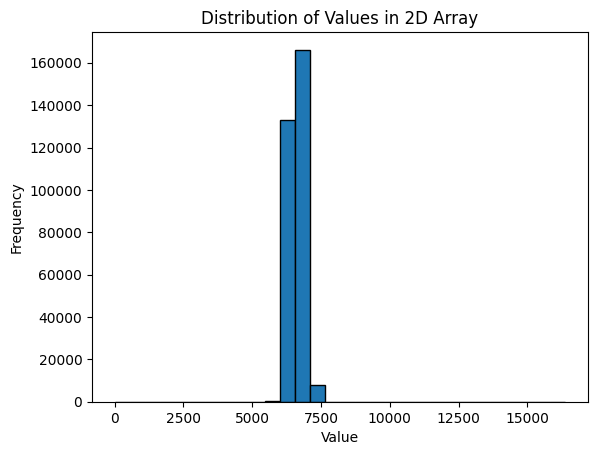

Mean: -78.15296204725904
Median: -78.23316465005465
Standard Deviation: 6.913626163461576


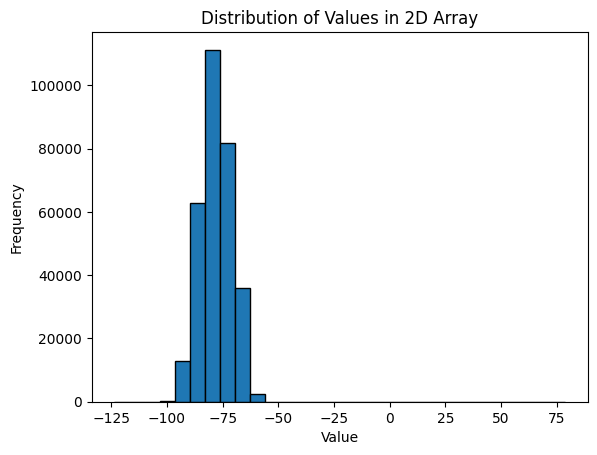

Mean: 13.215902706061524
Median: 13.229118678157686
Standard Deviation: 0.26212416683749606


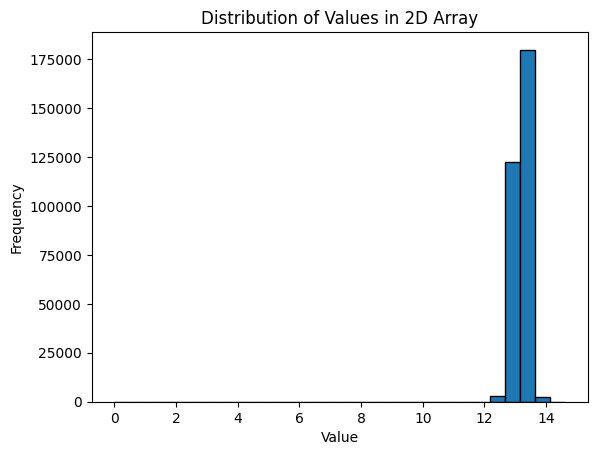

(480, 640, 2)
(480, 640)
(480, 640)
(480, 640)


In [43]:
meanof, medianof, std_devof = evaluate_distributions(of3)
shapeof = of3.shape
meang1,mediang1,std_devg1 = evaluate_distributions(g3[:,:,0])
shapeg1 = g3[:,:,0].shape
meang2,mediang2,std_devg2 = evaluate_distributions(g3[:,:,1])
shapeg2 = g3[:,:,1].shape
print(g3.shape)
print(shapeg1)
print(shapeg2)
print(shapeof)

In [ ]:
def generate_array(shape, mean, median, std_dev):
    array = np.random.normal(loc=mean, scale=std_dev, size=shape)
    adjustment = median - np.median(array)
    adjusted_array = array + adjustment
    return adjusted_array


In [44]:
random_g1 = generate_array(shapeg1, meang1,mediang1,std_devg1)
random_g2 = generate_array(shapeg2, meang2,mediang2, std_devg2)
random_of = generate_array(shapeof, meanof, medianof,std_devof)
random_g = np.stack((random_g1, random_g2), axis=-1)

In [45]:
import cv2
import numpy as np

def video_to_stack(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)
    cap.release()
    return np.stack(frames, axis=0)


In [47]:
path = "output-matching.avi"

stacked = video_to_stack(path)

In [49]:
def apply_correction(scene_image, offsets, responsivities, scene_temp, avg_black_body_temp):
    height, width = scene_image.shape
    corrected_image = np.zeros_like(scene_image)
    
    for i in range(height):
        for j in range(width):
            intercept = offsets[i, j]
            coef_fpa = responsivities[i, j, 0]
            coef_cn = responsivities[i, j, 1]
            expected_value = intercept + coef_fpa * scene_temp + coef_cn * avg_black_body_temp
            corrected_image[i, j] = scene_image[i, j] - expected_value
    
    return corrected_image

In [51]:
avg_black_body_temp = calibration_df['t_cn'].mean()
scene_temp = 20
# Process each scene image
corrected_scene_images = []
for img in stacked:
    corrected_image = apply_correction(img, random_of, random_g, scene_temp, avg_black_body_temp)
    corrected_scene_images.append(corrected_image)

# Convert corrected_scene_images to numpy array
corrected_scene_images = np.array(corrected_scene_images)



In [52]:
def save_video_from_images(images, output_filename, fps=60):
    """
    Save a sequence of images as a video.

    Parameters:
    images (list or array): List or array of images (each image should be a 2D or 3D NumPy array).
    output_filename (str): Output video filename (e.g., 'output.avi').
    fps (int): Frames per second for the video.
    """
    # Get the dimensions of the images
    height, width = images[0].shape[:2]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    for img in images:
        # Ensure image is in the correct format (uint8)
        img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        # If the image is grayscale, convert it to BGR
        if len(img_uint8.shape) == 2:
            img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        out.write(img_uint8)

    # Release everything when the job is finished
    out.release()

In [54]:
save_video_from_images(corrected_scene_images,"randomised.avi")